# Predicting Heart Disease using K-Nearest Neighbors (KNN) and Scikit-Learn

Heart disease remains one of the leading causes of death worldwide. Early detection can save lives by allowing timely intervention and lifestyle changes.

In this project, we use the [Heart Disease UCI dataset from Kaggle](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data) to build a machine learning model that predicts whether a patient is likely to develop heart disease based on clinical and lifestyle attributes.

We will implement the **K-Nearest Neighbors (KNN)** algorithm using `Scikit-Learn`, explore the dataset through EDA (Exploratory Data Analysis), and fine-tune the model to find the optimal number of neighbors for best performance.

This project demonstrates practical steps in:

- Working with healthcare data.
- Preprocessing and scaling features.
- Building and tuning a KNN classifier.
- Evaluating model performance using key metrics.

By the end, you’ll understand both the clinical meaning of the data and the mathematical logic behind KNN classification in real-world healthcare prediction.

## 1. Import Libraries

In [1]:
import warnings
import math

# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import f_oneway, chi2_contingency

# Silence unnecessary warnings
warnings.filterwarnings('ignore')

# Default plot styles
sns.set(style='white')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

## 2. Importing and Previewing the Dataset

In [2]:
# Load the dataset
data = pd.read_csv("heart_disease_uci.csv")

# Preview a few rows
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Check the general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


### Dataset Overview

The dataset contains **920 patient records** and **16 clinical features** relevant to heart disease prediction.
There are a mix of **numerical** (`age`, `trestbps`, `chol`, `thalach`, etc.) and **categorical** (`sex`, `cp`, `restecg`, `thal`, etc.) variables.

A few observations:

* Some columns like **`ca`**, **`thal`**, and **`slope`** have **substantial missing values**, which will need to be addressed during cleaning.
* The **target variable** is `num`, representing the presence or absence of heart disease.
* All records have valid `id` values, ensuring uniqueness.
* Categorical features are currently stored as text and will require encoding before model training.

Overall, the dataset looks consistent but will require **data cleaning and preprocessing** before modeling.


In [4]:
# Statistical information of numerical variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


### Statistical Summary of Numerical Features

The numerical summary provides a quick overview of the dataset’s scale, spread, and data quality:

- **Age:** The average age is around 53 years, with most patients between 47 and 60, representing a middle-aged population, a key demographic for heart disease.
- **Resting Blood Pressure (`trestbps`):** The mean value of 132 mm Hg is within a normal range, but the minimum value of 0 is medically invalid and should be treated as missing data.
- **Cholesterol (`chol`):** The mean is around 199 mg/dL, though the 0 value again indicates missing information that needs correction.
- **Maximum Heart Rate (`thalch`):** Most patients have a max heart rate between 120–157 bpm, typical for stress test data.
- **ST Depression (`oldpeak`):** Values range from -2.6 to 6.2, showing variation in ECG readings after exercise.
- **Number of Vessels (`ca`):** The mean of 0.68 suggests most patients have few major vessels affected.
- **Target (`num`):** The variable ranges from 0 to 4, representing heart disease severity, with an average close to 1, implying a mix of healthy and diseased cases.

Overall, the data looks consistent but contains impossible zero values in trestbps and chol, which will need cleaning before modeling.

In [5]:
# Statistical information of numerical variables
data.describe(include='object').T

,count,unique,top,freq
sex,920,2,Male,726
dataset,920,4,Cleveland,304
cp,920,4,asymptomatic,496
fbs,830,2,False,692
restecg,918,3,normal,551
exang,865,2,False,528
slope,611,3,flat,345
thal,434,3,normal,196


### Summary of Categorical Features

Here’s what the categorical summary tells us about the dataset:

- **Sex:** The dataset is male-dominated (79%), showing potential gender imbalance in the study population.
- **Dataset Origin:** The data combines samples from four sources, with Cleveland being the largest contributor. This mix could introduce slight variations across records.
- **Chest Pain Type (`cp`):** Nearly half the patients (496) experience asymptomatic chest pain, indicating they may not feel discomfort even when at risk, a critical heart disease indicator.
- **Fasting Blood Sugar (`fbs`):** Most patients (83%) have normal fasting blood sugar levels, showing diabetes is less common in this dataset.
- **Resting ECG (`restecg`):** A majority (551 patients) show normal ECG results, but abnormalities still exist.
- **Exercise-Induced Angina (`exang`):** Most patients (61%) do not experience angina during exercise.
- **Slope of ST Segment (slope):** The flat slope pattern is most frequent (345 patients), often associated with heart disease.
- **Thalassemia Result (`thal`)** Among the available data, “normal” thalassemia is the most common finding, but many entries are missing and will need cleaning.

Overall, the dataset captures a clinically relevant mix of cardiovascular indicators, though missing values and category imbalances will require attention during preprocessing.

## 3. Data Cleaning

Before building our model, we’ll clean and prepare the dataset to ensure data quality and consistency.

Here’s what we’ll do in this step:

- **Check Duplicates** – Identify and remove any duplicate records if they exist.
- **Handle Missing Values** – Several columns like `ca`, `thal`, and `slope` have missing data that we’ll address using suitable imputation methods.
- **Drop Irrelevant Columns** – The `id` column doesn’t contribute to prediction, so it will be removed.

These steps will help prepare a clean, well-structured dataset suitable for applying the KNN classifier.

### 3.1 Checking Duplicates

In [6]:
# Checking if there are any duplicate records
print(f'Duplicated Rows: {data.duplicated().sum()}')

Duplicated Rows: 0


### 3.2 Check for missing values

In [7]:
# Check missing values
num_missing_cols = ['trestbps', 'chol']
data[num_missing_cols] = data[num_missing_cols].replace(0, np.nan)

cat_cols = data.select_dtypes(include='object').columns
data[cat_cols] = data[cat_cols].replace(r'^\s*$', np.nan, regex=True)
print(data.isnull().sum().to_frame(name='Missing Values').assign(Type=data.dtypes))

          Missing Values     Type
id                     0    int64
age                    0    int64
sex                    0   object
dataset                0   object
cp                     0   object
trestbps              60  float64
chol                 202  float64
fbs                   90   object
restecg                2   object
thalch                55  float64
exang                 55   object
oldpeak               62  float64
slope                309   object
ca                   611  float64
thal                 486   object
num                    0    int64


In [8]:
# Identify numeric and categorical columns
num_cols = data.select_dtypes(include='number').columns
cat_cols = data.select_dtypes(exclude='number').columns

# Impute numeric columns with median (round 'ca' since it's a count variable)
for col in num_cols:
    if col == 'ca':
        data[col] = data[col].fillna(round(data[col].median()))
    else:
        data[col] = data[col].fillna(data[col].median())

# Impute categorical columns with mode or "Unknown" for large missingness
for col in cat_cols:
    if data[col].isnull().mean() > 0.3:
        data[col] = data[col].fillna("Unknown")
    else:
        data[col] = data[col].fillna(data[col].mode()[0])

### 3.3 Drop Unnecessary Columns

In [9]:
# Drop (id) as its just and identifier
data = data.drop(columns=['id'])

## 4. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand the distribution and relationships of different medical features. EDA helps reveal important patterns, detect outliers, and identify correlations that may influence heart disease risk. 

This understanding guides both **feature preparation** and **model design** for our KNN classifier.

### 4.1 Target Variable — (`num`)

Let’s begin by examining the distribution of our target variable **`num`**, which represents the presence and severity of heart disease. A value of `0` indicates **no heart disease**, while values `1–4` indicate **different levels of severity**.


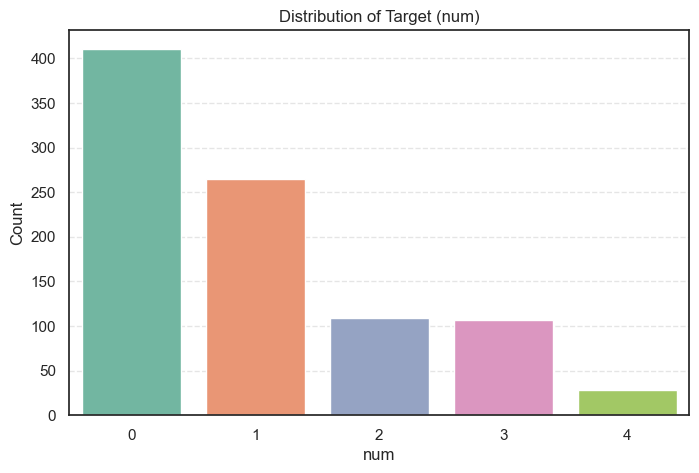

In [10]:
# Plot Distribution of target
sns.countplot(data=data, x='num', palette='Set2')
plt.title("Distribution of Target (num)")
plt.xlabel('num')
plt.ylabel('Count')
plt.show()

In [11]:
data['num'].value_counts().to_frame(name='Count').assign(
    Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

,Count,Percent
num,,
0,411,44.67
1,265,28.80
2,109,11.85
3,107,11.63
4,28,3.04


The distribution shows that:

- **44.7%** of patients have **no heart disease (`num = 0`)**.  
- **55.3%** have **some form of heart disease (`num > 0`)**, with most cases falling under **mild to moderate** severity (`num = 1` or `2`).

This indicates a **slight class imbalance**, but not extreme, making the dataset suitable for supervised classification tasks.  

It also suggests that heart disease is relatively common in this population, making it an informative dataset for predictive modeling.

### 4.2 Univariate Analysis — Numerical Features

In this step, we explore each **numerical variable** independently to understand its **distribution, spread, and presence of outliers**.
  
This helps reveal underlying data patterns, identify skewed variables, and detect potential outliers that may affect the KNN model, since KNN relies heavily on distance-based calculations.

We’ll use summary statistics and visualizations to gain insights into the overall health profile of patients in this dataset.

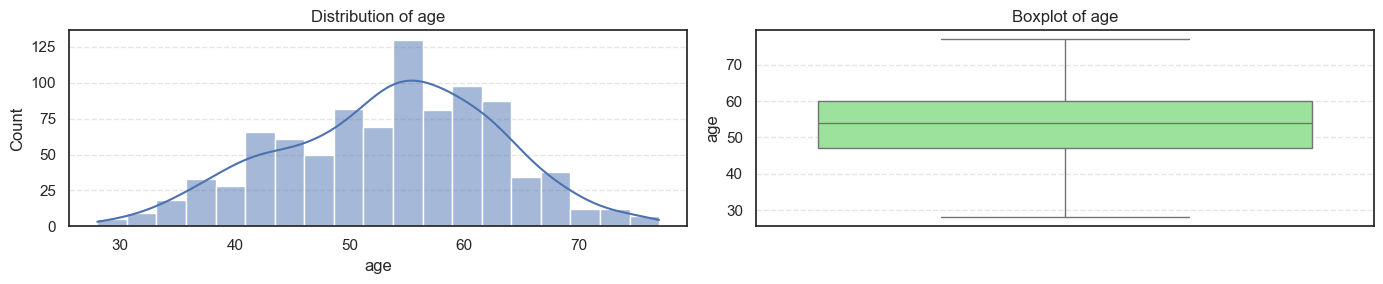

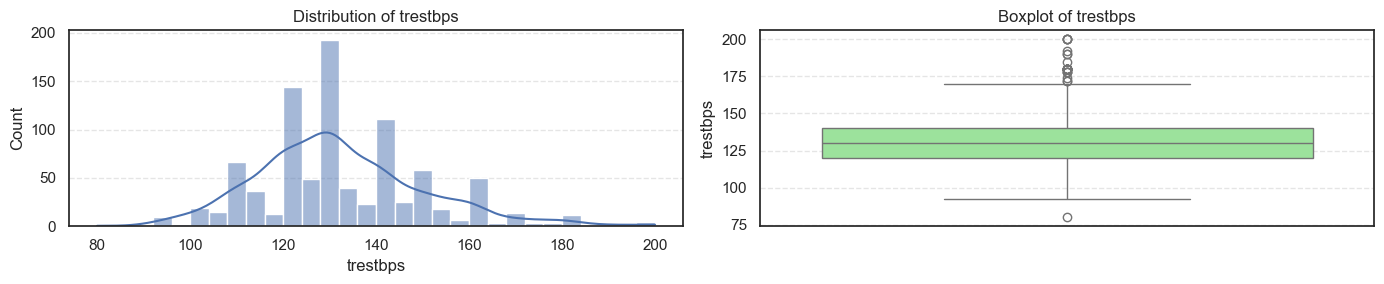

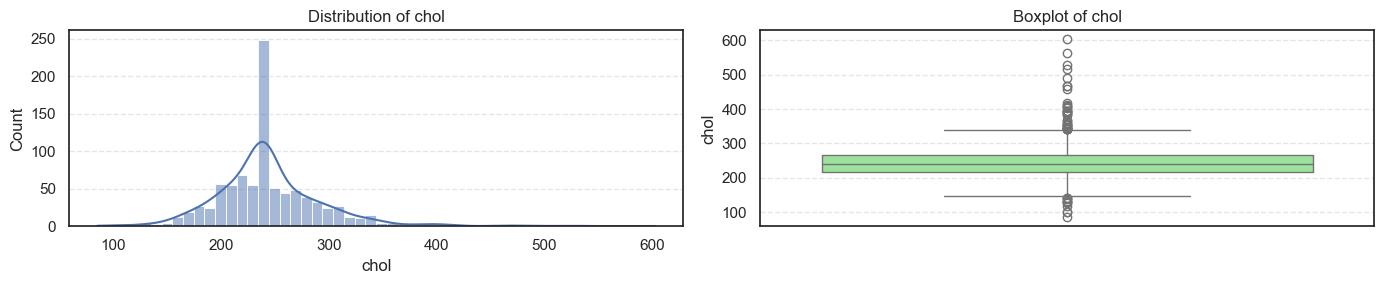

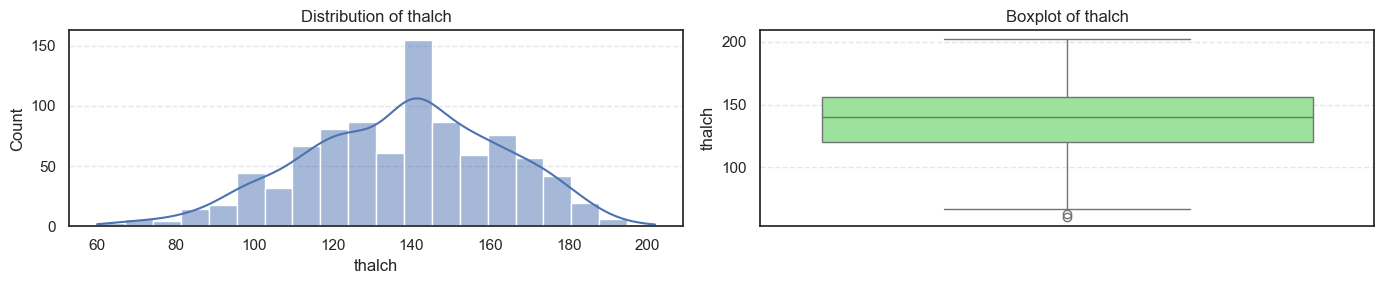

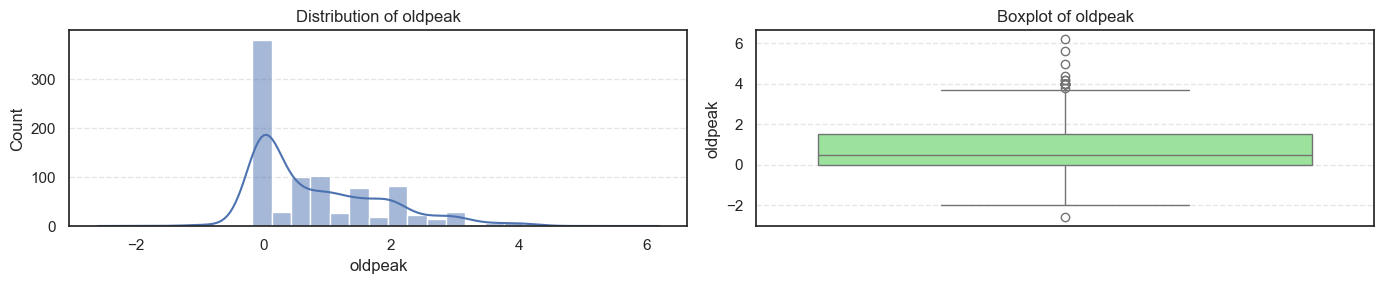

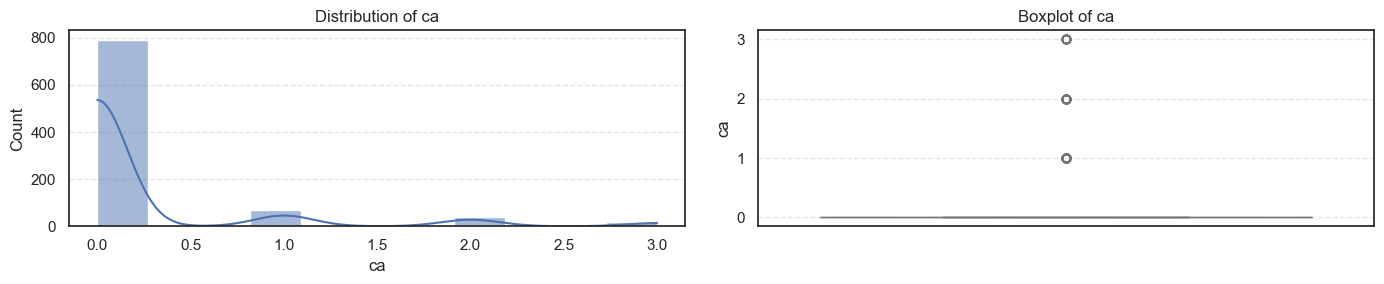

In [12]:
# Select numerical columns
num_cols = data.select_dtypes(include='number').columns.drop('num')

# Plot distributions of numerical variables
for col in num_cols:
    plt.figure(figsize=(14, 3))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, y=col, color='lightgreen')
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

- The count and box plots show clear patterns across the numerical variables.  
- Most variables appear to follow expected clinical trends. **`Age`** and **maximum heart rate (`thalch`)** display roughly symmetric distributions.  
- Features like **resting blood pressure (`trestbps`)** and **cholesterol (`chol`)** show a wider range, with visible outliers on the higher end.  
- **`Oldpeak`** and **`ca`** have right-skewed distributions, where most patients cluster at lower values and only a few show extreme readings.  
- These patterns suggest the dataset captures realistic medical variability among patients with different levels of heart disease risk.

In [13]:
# Check for outliers and skew
for col in num_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]

    print(f'=== {col} ===')
    print(f'Outliers: {len(outliers)}')
    print(f'Skew: {data[col].skew()}', '\n')

=== age ===
Outliers: 0
Skew: -0.195993861608106 

=== trestbps ===
Outliers: 27
Skew: 0.675591653030119 

=== chol ===
Outliers: 47
Skew: 1.572905326744683 

=== thalch ===
Outliers: 2
Skew: -0.2350174024294091 

=== oldpeak ===
Outliers: 16
Skew: 1.1347025952263665 

=== ca ===
Outliers: 128
Skew: 2.965211622084169 



- Outlier detection using the IQR method shows that **`trestbps`**, **`chol`**, **`oldpeak`**, and **`ca`** contain several high-end outliers.  
- This is consistent with patients who have elevated blood pressure, cholesterol, or more severe ST depression and coronary obstruction.  
- Skewness values confirm mild right skew in **`trestbps`**, **`chol`**, and **`oldpeak`**, while **`ca`** is strongly skewed due to most patients having few or no blocked vessels.  
- Since these are clinically valid variations rather than data errors, the outliers will be **kept** for further analysis and modeling.

### 4.3 Bivariate Analysis: Numerical Variables vs Target

In this section, we explore how each numerical feature varies across different levels of the **target variable (`num`)**,  
which represents the **severity of heart disease (0–4)**.  

This helps identify which clinical measures, such as age, blood pressure, or cholesterol, differ meaningfully between healthy and heart disease patients. Strong differences across target levels can signal **predictive power** for the KNN model.

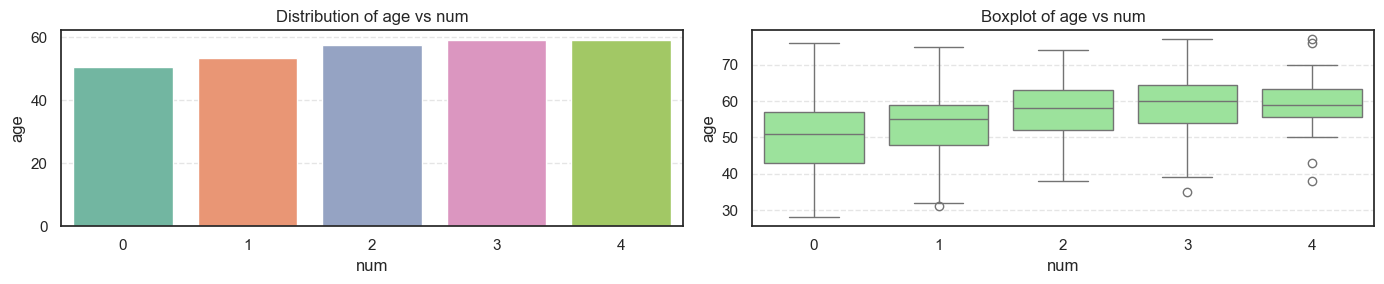

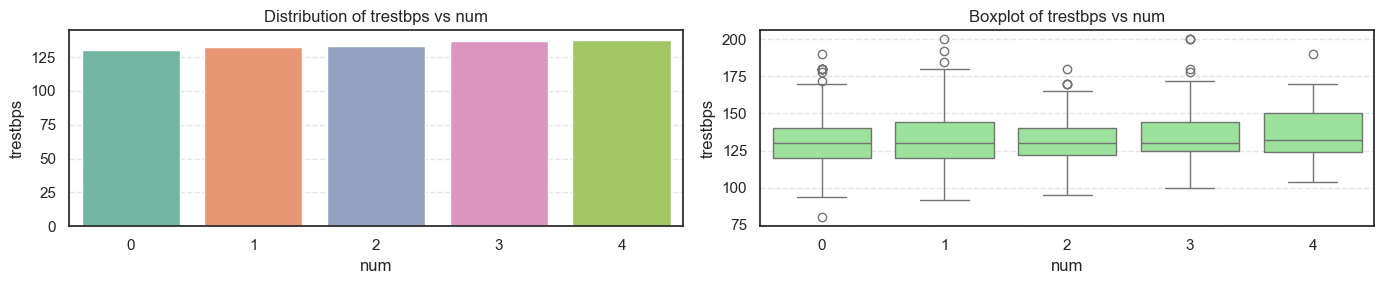

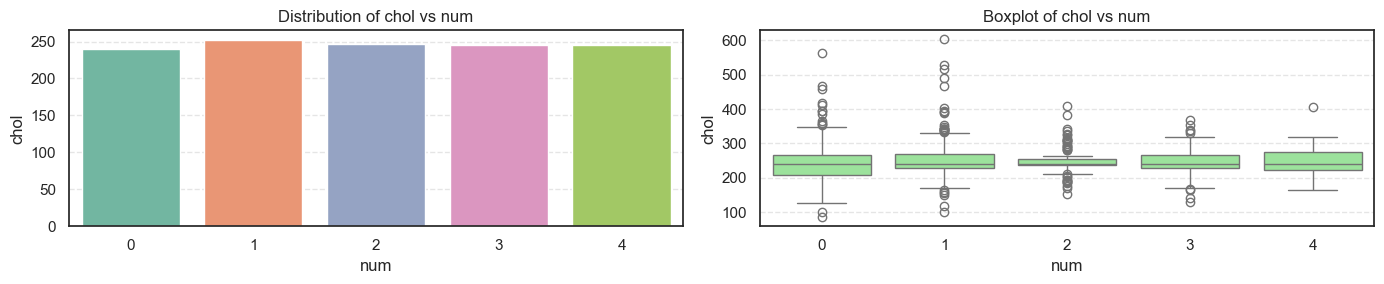

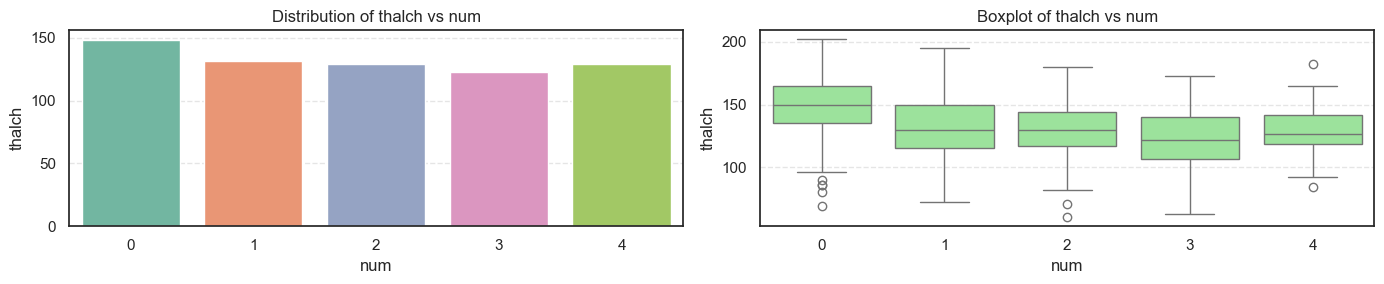

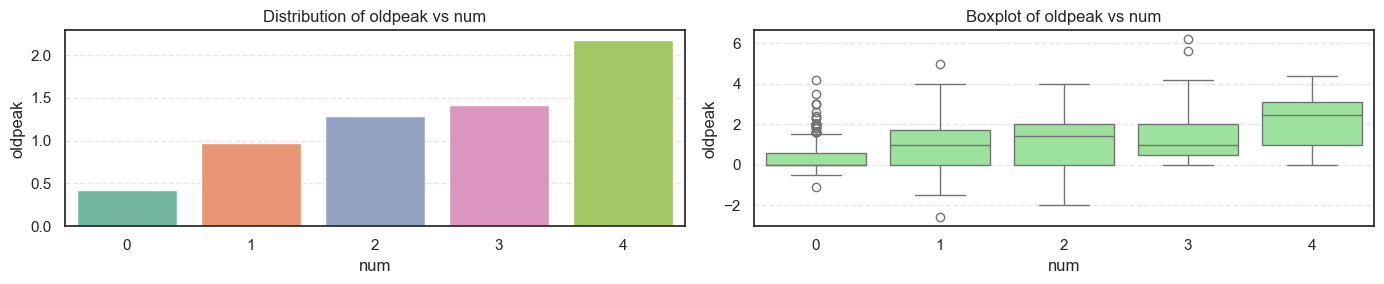

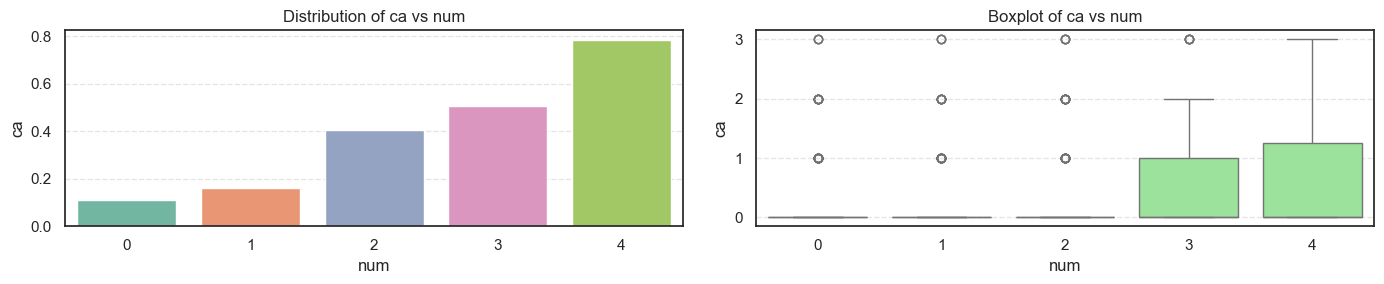

In [14]:
# Plot numerical variables vs target
for col in num_cols:
    plt.figure(figsize=(14, 3))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.barplot(data=data, x='num', y=col, palette='Set2', estimator='mean', ci=False)
    plt.title(f'Distribution of {col} vs num')
    plt.xlabel('num')
    plt.ylabel(col)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x='num', y=col, color='lightgreen')
    plt.title(f'Boxplot of {col} vs num')

    plt.tight_layout()
    plt.show()

As we examine the relationship between each numeric variable and the target variable `num` (which represents the presence and severity of heart disease), several patterns become clear:

- **`Age`:** The average age increases steadily from patients with `num` = 0 to `num` = 4, suggesting that heart disease risk tends to rise with age.
- **Resting Blood Pressure (`trestbps`):** Mean blood pressure shows a gradual upward trend with disease severity, indicating that hypertensive patients are more likely to have advanced heart conditions.
- **Cholesterol (`chol`):** Cholesterol levels are high across all groups, peaking slightly in mild-to-moderate disease categories (`num` = 1 and `num` = 2), showing its general association with cardiac risk.
- **Maximum Heart Rate (`thalch`):** There is a clear decline in maximum heart rate as num increases. This aligns with medical expectations, patients with more severe heart disease tend to have lower exercise tolerance.
- **ST Depression (`oldpeak`):** Mean oldpeak values rise sharply with disease severity, showing a strong positive relationship with heart abnormalities observed during stress tests.
- **Major Vessels (`ca`):** The number of vessels colored by fluoroscopy increases with disease level, suggesting greater arterial blockage or narrowing in more severe cases.

Overall, the barplots highlight these increasing and decreasing trends across disease levels, while the boxplots reveal the variation and overlap in distributions, emphasizing that while patterns exist, patient profiles remain diverse across all stages of heart disease.

In [15]:
# Statistical significance testing
for col in num_cols:
    groups = [groups[col] for _, groups in data.groupby('num')]
    f_stat, p_value = f_oneway(*groups)
    print(f'=== {col} ===')
    print(f'f-stat: {f_stat:.4f}, p-value: {p_value}')
    print(f'Null Hypothesis (Ho): {col} is the same across heart disease.')
    decision = "Reject null hypothesis." if p_value < 0.05 else "Fail to reject null hypothesis."
    print(f'Decision: {decision}', '\n')

=== age ===
f-stat: 31.2261, p-value: 2.1062091183092783e-24
Null Hypothesis (Ho): age is the same across heart disease.
Decision: Reject null hypothesis. 

=== trestbps ===
f-stat: 4.1064, p-value: 0.002644648135897837
Null Hypothesis (Ho): trestbps is the same across heart disease.
Decision: Reject null hypothesis. 

=== chol ===
f-stat: 2.3366, p-value: 0.05381629783022461
Null Hypothesis (Ho): chol is the same across heart disease.
Decision: Fail to reject null hypothesis. 

=== thalch ===
f-stat: 42.1412, p-value: 1.8297325834062407e-32
Null Hypothesis (Ho): thalch is the same across heart disease.
Decision: Reject null hypothesis. 

=== oldpeak ===
f-stat: 49.9764, p-value: 4.549122808950497e-38
Null Hypothesis (Ho): oldpeak is the same across heart disease.
Decision: Reject null hypothesis. 

=== ca ===
f-stat: 18.3136, p-value: 1.7405740611858642e-14
Null Hypothesis (Ho): ca is the same across heart disease.
Decision: Reject null hypothesis. 



The one-way ANOVA test was used to determine whether the mean values of each numeric feature differ significantly across the five heart disease categories (num).

- Features such as **age**, **resting blood pressure**, **maximum heart rate**, **ST depression (`oldpeak`)**, and **number of major vessels (`ca`)** all returned p-values < 0.05, indicating statistically significant differences between disease levels.
- **Cholesterol (`chol`)** showed a **p-value slightly above 0.05**, suggesting its mean values do not vary significantly across categories in this dataset.

Overall, most physiological indicators demonstrate meaningful variation with disease severity, confirming their importance as predictive features for heart disease classification.

### 4.5 Univariate Analysis — Categorical Features

In this section, we analyze each categorical variable individually to understand its frequency distribution and how the categories are represented within the dataset.

This helps identify imbalances, uncommon categories, or dominant groups that may influence model learning.

By visualizing categorical features such as `sex`, chest pain type (`cp`), fasting blood sugar (`fbs`), and exercise-induced angina (`exang`), we gain insight into patient characteristics and potential risk factors related to heart disease.

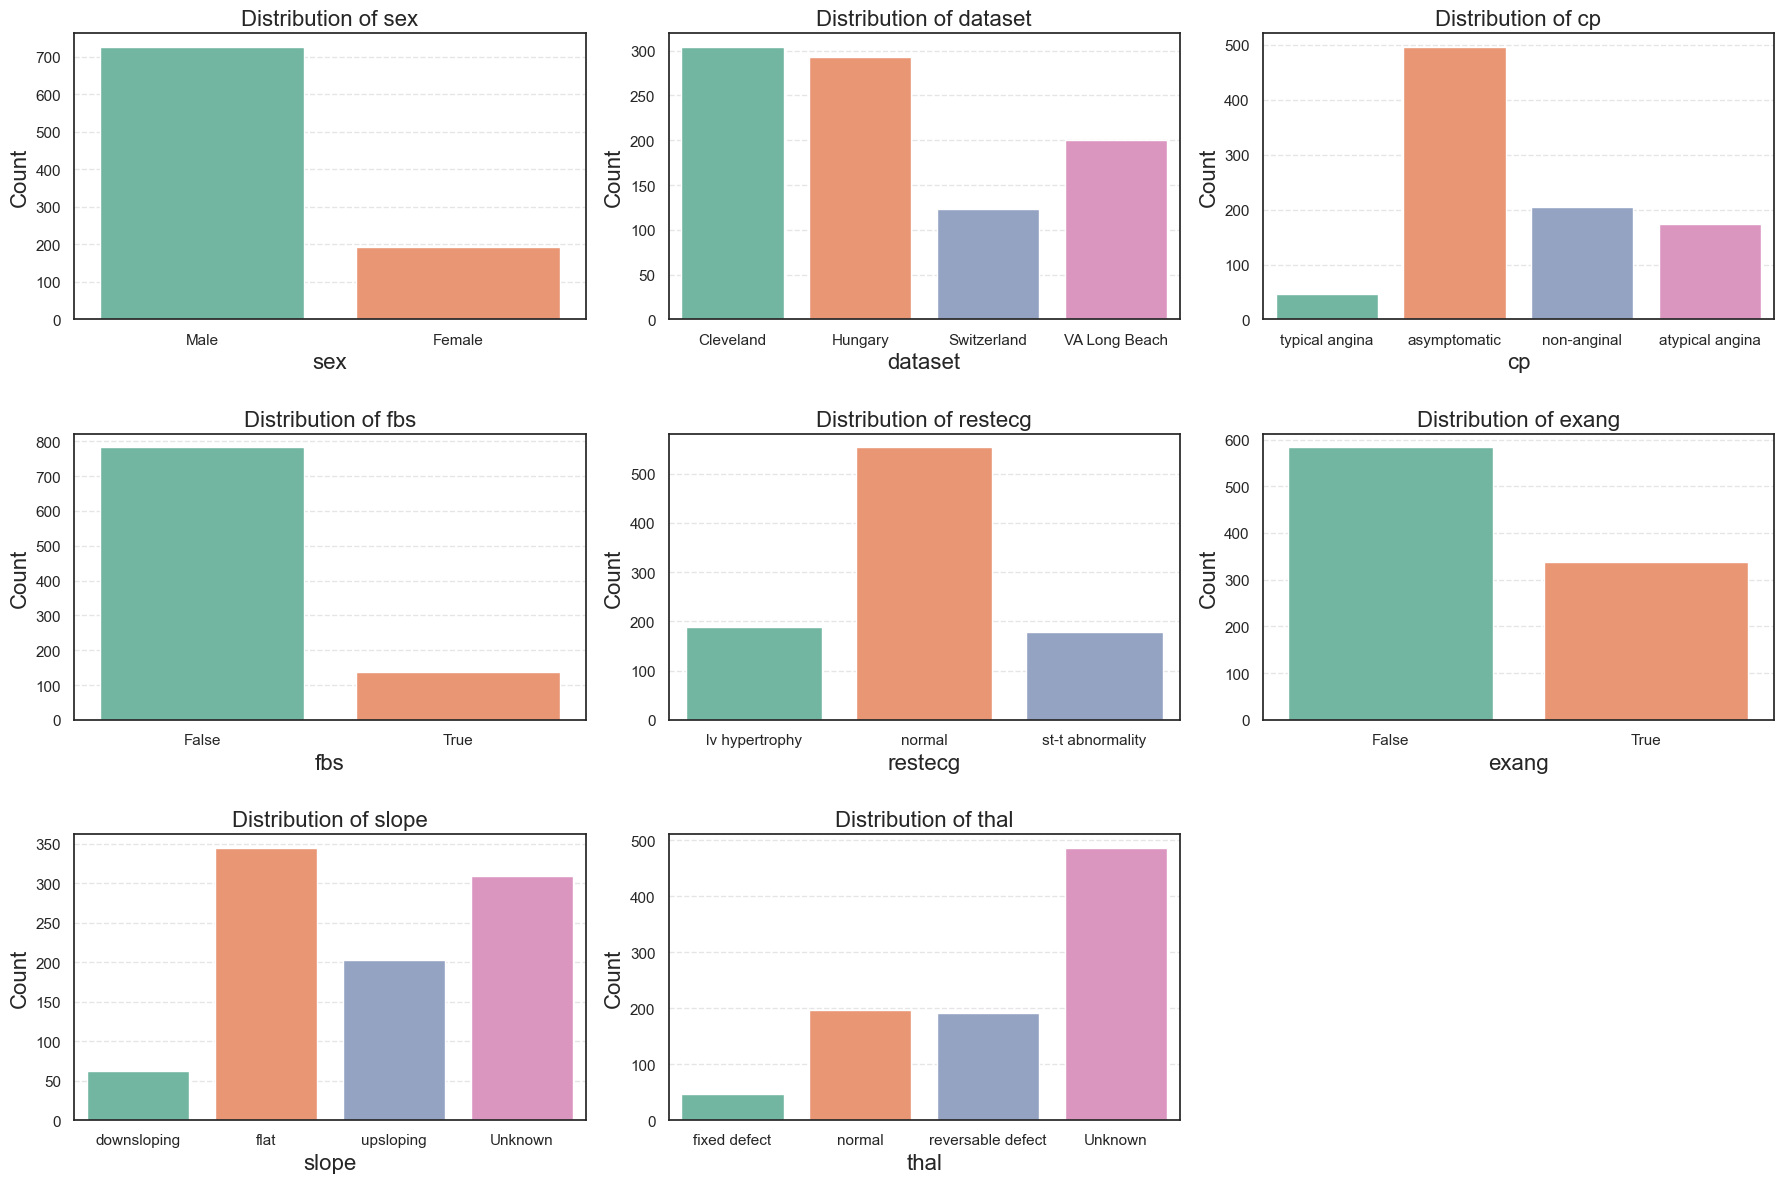

In [16]:
# Select categorical columns
cat_cols = data.select_dtypes(exclude='number').columns

# Plot categorical distributions
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=col, palette='Set2')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=16)
    plt.ylabel('Count', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [17]:
# Calculate the categorical distibutions
for col in cat_cols:
    counts = data[col].value_counts().to_frame(name='Count').assign(
        Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))
    print(f'=== {col} ===')
    print(counts, '\n')

=== sex ===
        Count  Percent
sex                   
Male      726    78.91
Female    194    21.09 

=== dataset ===
               Count  Percent
dataset                      
Cleveland        304    33.04
Hungary          293    31.85
VA Long Beach    200    21.74
Switzerland      123    13.37 

=== cp ===
                 Count  Percent
cp                             
asymptomatic       496    53.91
non-anginal        204    22.17
atypical angina    174    18.91
typical angina      46     5.00 

=== fbs ===
       Count  Percent
fbs                  
False    782     85.0
True     138     15.0 

=== restecg ===
                  Count  Percent
restecg                         
normal              553    60.11
lv hypertrophy      188    20.43
st-t abnormality    179    19.46 

=== exang ===
       Count  Percent
exang                
False    583    63.37
True     337    36.63 

=== slope ===
             Count  Percent
slope                      
flat           345    37.50
Unkn

The categorical variables show several notable patterns across the dataset:

- **Sex:** The dataset is male-dominated (≈79%), which may bias model learning toward male-specific patterns of heart disease.
- **Dataset Origin:** Most records come from **Cleveland (33%)** and **Hungary (32%)**, while others like **Switzerland** and **VA Long Beach** contribute smaller portions. This mix indicates diverse population sources.
- **Chest Pain Type (`cp`):** Over half of the patients (≈54%) reported asymptomatic chest pain, a common indicator in advanced heart disease, while typical angina is the least frequent (≈5%).
- **Fasting Blood Sugar (`fbs`):** Only 15% of patients have elevated fasting blood sugar, suggesting diabetes is present but not dominant.
- **Resting ECG (`restecg`):** Most patients (≈60%) had normal ECG readings, with left ventricular hypertrophy and ST-T abnormalities evenly distributed among the rest.
- **Exercise-Induced Angina (`exang`):** Around 63% of patients did not experience angina during exercise, implying many cases were not stress-induced.
- **Slope:** The flat slope dominates (≈38%), consistent with ischemic heart conditions, but a third of records are unknown, requiring cautious interpretation.
- **Thalassemia (`thal`):** Over half (≈53%) of the values are unknown, while the rest mostly fall under normal or reversible defect, both clinically relevant in diagnosing cardiac abnormalities.

Overall, the dataset shows imbalances and missingness in several categorical features (especially thal and slope). These will need careful handling during data preprocessing to ensure reliable model training.

### 4.6 Bivariate Analysis: Categorical Variables vs Target

In this section, we examine how each categorical feature relates to the target variable (`num`), which represents the severity of heart disease.

Understanding these relationships helps identify which categorical factors (like chest pain type, ECG results, or sex) have stronger links to heart disease presence or severity.

This analysis is especially useful before model training, as it highlights potential predictors and reveals any trends worth encoding or emphasizing later.

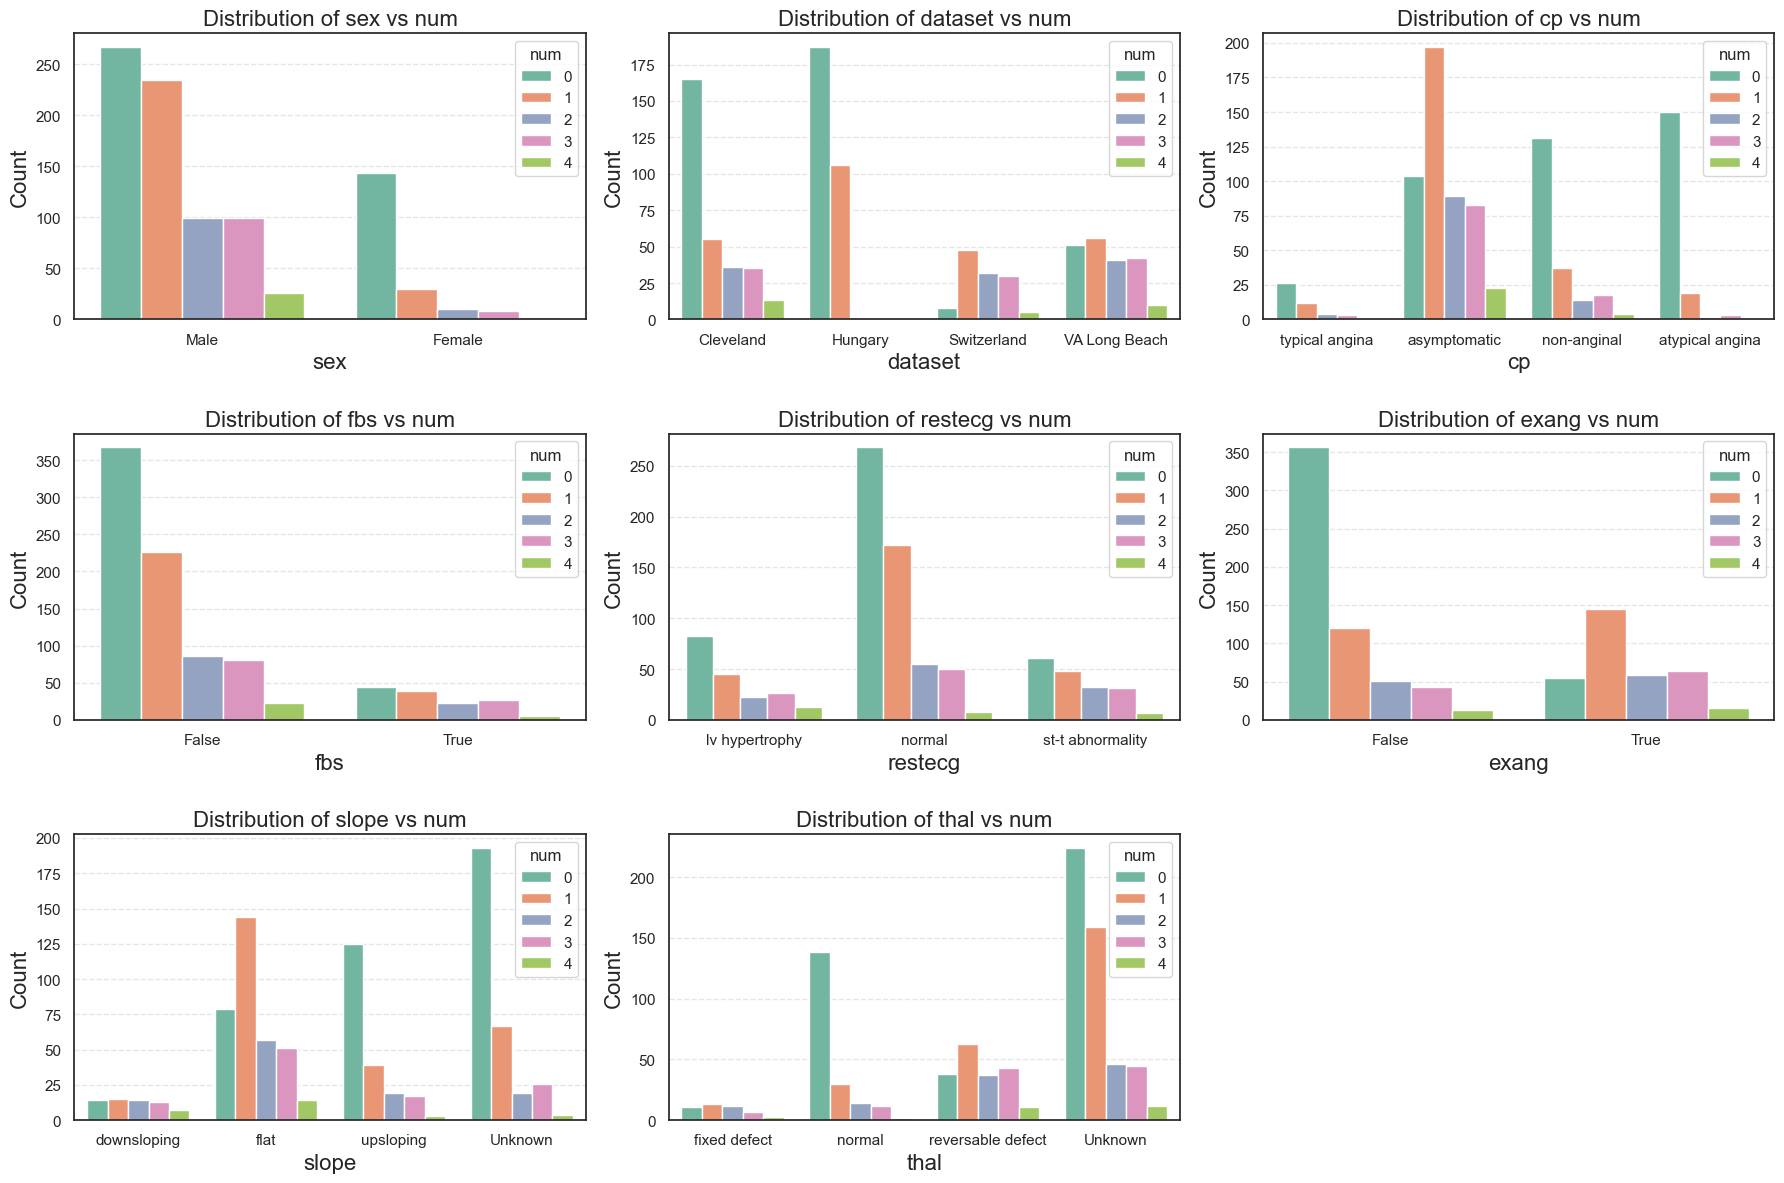

In [18]:
# Plot category distribution across target (num)
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=col, hue='num', palette='Set2')
    plt.title(f'Distribution of {col} vs num', fontsize=16)
    plt.xlabel(col, fontsize=16)
    plt.ylabel('Count', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [19]:
# Calculate category distribution across target (num)
for col in cat_cols:
    cross_table = pd.crosstab(data[col], data['num'], normalize="index").round(2)
    print(f'=== {col} ===')
    print(cross_table, '\n')

=== sex ===
num        0     1     2     3     4
sex                                 
Female  0.74  0.15  0.05  0.04  0.01
Male    0.37  0.32  0.14  0.14  0.04 

=== dataset ===
num               0     1     2     3     4
dataset                                    
Cleveland      0.54  0.18  0.12  0.12  0.04
Hungary        0.64  0.36  0.00  0.00  0.00
Switzerland    0.07  0.39  0.26  0.24  0.04
VA Long Beach  0.26  0.28  0.20  0.21  0.05 

=== cp ===
num                 0     1     2     3     4
cp                                           
asymptomatic     0.21  0.40  0.18  0.17  0.05
atypical angina  0.86  0.11  0.01  0.02  0.00
non-anginal      0.64  0.18  0.07  0.09  0.02
typical angina   0.57  0.26  0.09  0.07  0.02 

=== fbs ===
num       0     1     2    3     4
fbs                               
False  0.47  0.29  0.11  0.1  0.03
True   0.32  0.28  0.17  0.2  0.04 

=== restecg ===
num                  0     1     2     3     4
restecg                                       
lv 

The relationship between categorical features and heart disease (`num`) reveals several important patterns:

- **Sex:** Males show a higher prevalence of heart disease across all severity levels, while most females fall under the non-disease category (`num` = 0).
- **Dataset Origin:** The Cleveland and Hungary datasets have more patients with lower heart disease severity, while Switzerland and VA Long Beach show more cases with advanced stages (`num` ≥ 2).
- **Chest Pain Type (`cp`):** Patients with asymptomatic chest pain are more likely to have heart disease (higher `num` values), while atypical and non-anginal pain types are associated with non-disease cases.
- **Fasting Blood Sugar (`fbs`):** Individuals with high fasting blood sugar (`True`) tend to have higher disease severity compared to those with normal levels.
- **Resting ECG (`restecg`):** Abnormal ECG readings, especially st-t abnormalities and left ventricular hypertrophy, are more frequent among those with heart disease.
- **Exercise-Induced Angina (`exang`):** Those with exercise-induced angina (`True`) show much higher proportions of heart disease, indicating it as a strong risk indicator.
- **Slope:** Patients with a flat or downsloping ST segment tend to have more heart disease cases compared to upsloping patterns.
- **Thalassemia (`thal`):** Reversible and fixed defects in `thalassemia` are more common among patients with heart disease, while a normal `thal` pattern is linked to healthier individuals.

Overall, features such as `sex`, chest pain type, exercise-induced angina, `slope`, and `thal` show the strongest relationships with the target variable, making them potentially valuable predictors for the KNN model.

In [20]:
# Statistical significance testing
for col in cat_cols:
    cross_table = pd.crosstab(data[col], data['num'])
    stats, p_value, _, _ = chi2_contingency(cross_table)
    print(f'=== {col} ===')
    print(f'Stats: {stats:.4f}, P-Value: {p_value}')
    print(f'Null Hypothesis (Ho): {col} has no relations with heart disease.')
    decision = "Reject the null hypothesis." if p_value < 0.05 else "Fail to reject the null hypothesis."
    print(f'Decision: {decision}', '\n')

=== sex ===
Stats: 87.7295, P-Value: 3.996551117702751e-18
Null Hypothesis (Ho): sex has no relations with heart disease.
Decision: Reject the null hypothesis. 

=== dataset ===
Stats: 257.0015, P-Value: 4.7344983780753835e-48
Null Hypothesis (Ho): dataset has no relations with heart disease.
Decision: Reject the null hypothesis. 

=== cp ===
Stats: 272.0407, P-Value: 3.4048663230325624e-51
Null Hypothesis (Ho): cp has no relations with heart disease.
Decision: Reject the null hypothesis. 

=== fbs ===
Stats: 18.1117, P-Value: 0.0011735999765530689
Null Hypothesis (Ho): fbs has no relations with heart disease.
Decision: Reject the null hypothesis. 

=== restecg ===
Stats: 39.5953, P-Value: 3.8104547840523323e-06
Null Hypothesis (Ho): restecg has no relations with heart disease.
Decision: Reject the null hypothesis. 

=== exang ===
Stats: 174.1887, P-Value: 1.3193441828978815e-36
Null Hypothesis (Ho): exang has no relations with heart disease.
Decision: Reject the null hypothesis. 

===

The Chi-square test of independence was performed to assess whether categorical features are associated with heart disease (`num`).

All variables, including **sex, dataset, chest pain type (`cp`), fasting blood sugar (`fbs`), resting ECG (`restecg`), exercise-induced angina (`exang`), slope**, and **`thal`**, returned **p-values below 0.05**.

This means we **reject the null hypothesis** for all features, confirming that each has a **statistically significant relationship with heart disease presence or severity**.

These results validate the earlier visual findings and highlight categorical predictors like **`cp`**, **`sex`**, and **`exang`** as strong contributors to heart disease classification.

## 5. Feature Encoding

Many of our dataset’s features are categorical, meaning they contain text labels such as "`Male`", "`Female`", or "`asymptomatic`".

Since machine learning models like KNN require numerical inputs, we need to convert these categorical variables into numbers.

In [21]:
data_encoded = data.copy()

# Binary encoding 
binary_cols = ['sex', 'fbs', 'exang']
rep_dict = {'Male': 1, 'Female': 0, True: 1, False: 0}
data_encoded[binary_cols] = data_encoded[binary_cols].replace(rep_dict)

# Ordinal encoding
cp_mapping = {
    'typical angina': 0,
    'atypical angina': 1,
    'non-anginal': 2,
    'asymptomatic': 3
}

slope_mapping = {
    'upsloping': 0,
    'flat': 1,
    'downsloping': 2,
    'Unknown': 3
}

thal_mapping = {
    'normal': 0,
    'fixed defect': 1,
    'reversable defect': 2,
    'Unknown': 3
}

data_encoded['cp'] = data_encoded['cp'].replace(cp_mapping)
data_encoded['slope'] = data_encoded['slope'].replace(slope_mapping)
data_encoded['thal'] = data_encoded['thal'].replace(thal_mapping)

# Nominal encoding
ohe = OneHotEncoder()
for col in ['dataset', 'restecg']:
    matrix = ohe.fit_transform(data_encoded[[col]]).toarray()
    categories = ohe.get_feature_names_out([col])
    data_encoded[categories] = matrix.astype(int)
    data_encoded = data_encoded.drop(columns=[col])

data_encoded.head()

,age,sex,cp,trestbps,chol,fbs,thalch,exang,oldpeak,slope,ca,thal,num,dataset_Cleveland,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality
0,63,1,0,145.0,233.0,1,150.0,0,2.3,2,0.0,1,0,1,0,0,0,1,0,0
1,67,1,3,160.0,286.0,0,108.0,1,1.5,1,3.0,0,2,1,0,0,0,1,0,0
2,67,1,3,120.0,229.0,0,129.0,1,2.6,1,2.0,2,1,1,0,0,0,1,0,0
3,37,1,2,130.0,250.0,0,187.0,0,3.5,2,0.0,0,0,1,0,0,0,0,1,0
4,41,0,1,130.0,204.0,0,172.0,0,1.4,0,0.0,0,0,1,0,0,0,1,0,0


## 6. Implementing K-Nearest Neighbors (KNN)

* We now train a **K-Nearest Neighbors (KNN)** classifier to predict heart disease.  
* Since KNN is a distance-based algorithm, all features are standardized before training.  
* The dataset is split into training and testing sets, the model is trained, and its performance is evaluated.  
* We also experiment with different values of **K** to identify the optimal number of neighbors that gives the best performance.

### Step 1. Data Preparation

In [22]:
# Convert target to binary
data_encoded['num'] = data_encoded['num'].apply(lambda x: 1 if x > 0 else 0)

# Separate features from target
X = data_encoded.drop(columns=['num'])
y = data_encoded['num']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 2. Train Base Model

In [23]:
# Initialize and train KNN model with default k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)
print(f'y_pred: {y_pred[:20]}')

y_pred: [0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1]


### Step 3. Model Evaluation

In [24]:
# Evaluation helper function
def evaluate_model(y_true, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 4)}')
    print(f'Precision: {round(precision_score(y_true, y_pred, average='macro'), 4)}')
    print(f'Recall: {round(recall_score(y_true, y_pred, average='macro'), 4)}')
    print(f'F1 Score: {round(f1_score(y_true, y_pred, average='macro'), 4)}')


evaluate_model(y_test, y_pred)

Accuracy: 0.8152
Precision: 0.8142
Recall: 0.8106
F1 Score: 0.812


After converting the target variable `num` into a **binary classification** problem (`0` = No Heart Disease, `1` = Heart Disease Present), the baseline KNN model with **k = 5** achieved the following performance:

- **Accuracy:** 81.5%  
- **Precision:** 81.4%  
- **Recall:** 81.1%  
- **F1 Score:** 81.2% 

With this solid baseline established, we can now proceed to **tune the number of neighbors (k)** to explore whether model performance can be further optimized.

### Step 4. Hyperparameter Tuning (Optimal K Selection)

In [25]:
# Test values for K
max_k = 50
f1_scores = []

for k in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    score = f1_score(y_test, preds, average='macro')
    f1_scores.append((k, score))

f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Scores']).set_index('K')
f1_results

,F1 Scores
K,
1,0.752799
2,0.760615
3,0.802009
4,0.797568
5,0.812019
6,0.796746
7,0.823077
8,0.823565
9,0.828847


We evaluated the KNN model across a range of **k values (1–50)** to identify the optimal number of neighbors that provides the best trade-off between bias and variance.

The **F1-scores** ranged from **0.75 to 0.85**, with the **best performance (≈0.85)** achieved around **k = 14–16**.  

This trend indicates that:
- Smaller values of `k` (1–3) tend to **overfit**, capturing noise and outliers rather than true patterns.
- Larger `k` values (beyond 20) cause **underfitting**, as the model becomes overly generalized and loses sensitivity to class distinctions.

Overall, **KNN achieved strong and stable performance** once properly tuned, highlighting the importance of **hyperparameter optimization** in improving accuracy and generalization for distance-based classifiers.

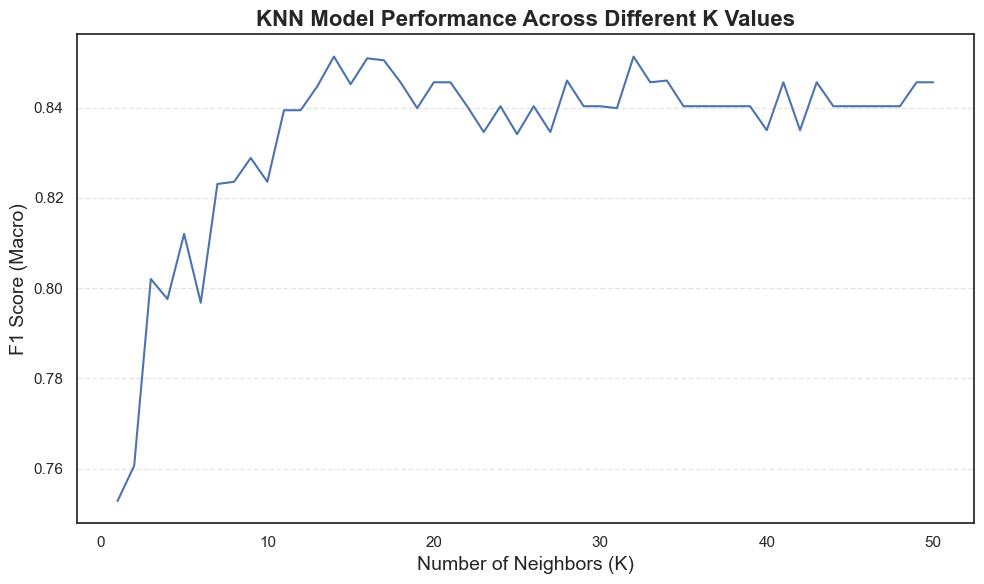

In [26]:
# Plot F1-Score vs K using
plt.figure(figsize=(10, 6))
sns.lineplot(data=f1_results, x='K', y='F1 Scores')
plt.title("KNN Model Performance Across Different K Values", fontsize=16, fontweight='bold')
plt.xlabel("Number of Neighbors (K)", fontsize=14)
plt.ylabel("F1 Score (Macro)", fontsize=14)
plt.tight_layout()
plt.show()

The line plot illustrates how the **F1-score** varies as the number of neighbors (`k`) increases from 1 to 50.  

From the trend, the model’s performance improves steadily from lower `k` values and begins to **stabilize around `k = 13–16`**, achieving its **peak F1-score (~0.85)**.  

This indicates that the KNN model finds an optimal balance between **bias and variance** within this range, small enough to capture meaningful local patterns, yet large enough to avoid overfitting.

After `k ≈ 20`, the F1-score plateaus and shows minimal variation, suggesting that increasing `k` further provides **no substantial gain in predictive power**.  

Overall, this analysis confirms that:
- **Very low k-values (1–3)** overfit the data by reacting too strongly to local noise.  
- **Moderate k-values (13–16)** yield the most stable and accurate results.  
- **Larger k-values (>25)** begin to underfit, diluting class distinctions as more neighbors are averaged.

The optimal K range identified here will be used for the final model evaluation.

## Project Conclusion

In this project, we built a **K-Nearest Neighbors (KNN)** model using **Scikit-Learn** to predict the presence of **heart disease** based on patient medical records from the **UCI Heart Disease Dataset**.

Through a structured workflow of **data cleaning**, **encoding**, **scaling**, and **hyperparameter tuning**, the model achieved strong predictive performance with an **accuracy of 81.5%** and an **F1-score of 0.85** after converting the target variable into a binary classification problem.

Key takeaways include:
- Proper **data preprocessing** (handling missing values, encoding categorical features, and scaling) is critical for distance-based algorithms like KNN.  
- **Feature scaling** ensures that all attributes contribute equally to the distance calculation, significantly improving performance.  
- The choice of **k** greatly influences model behavior, small `k` values lead to overfitting, while large values may underfit.  
- **Tuning the k parameter** revealed that the optimal range (≈13–16) provides the best trade-off between bias and variance.

Overall, this project demonstrates how a simple yet powerful algorithm like **KNN** can effectively classify heart disease risk when properly tuned and preprocessed.  

It also reinforces key machine learning concepts such as **distance metrics, model evaluation, and hyperparameter optimization**, making it a valuable foundation for healthcare-related predictive modeling.